In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style
import os
from pathlib import Path

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

## Part1 : Question 1

**Data loading**

We work with the Ninapro DB1 data stored in the project folder:

- Root: `Data/s2/S2_A1_E1/`
- File: `S2_A1_E1.mat`

In this question we only need **subject 2** and **exercise S2\_A1\_E1**, which are already selected in this file.

In [2]:
# --- Paths ---
current_dir = os.getcwd()
mat_path = os.path.join(current_dir, "Data", "S2", "S2_A1_E1")

data = loadmat(mat_path, squeeze_me=True)
list(data.keys())

['__header__',
 '__version__',
 '__globals__',
 'subject',
 'exercise',
 'stimulus',
 'emg',
 'glove',
 'restimulus',
 'repetition',
 'rerepetition']

From the `.mat` file we extract:

- `emg` : EMG envelope (already RMS-processed and band-pass filtered by the Otto Bock electrodes).
- `restimulus` : **relabelled** movement labels (after GLR-based relabelling in the Ninapro pipeline).
- `rerepetition` : **relabelled** repetition index.

We also read `subject` and `exercise` to double-check we are using the correct data.
Sampling frequency is fixed to **100 Hz** as described in the paper.

In [3]:
# Convert to numpy arrays with convenient shapes
emg = np.asarray(data["emg"], dtype=float)              # [T x n_channels]
restimulus = np.asarray(data["restimulus"]).ravel()     # [T]
rerepetition = np.asarray(data["rerepetition"]).ravel() # [T]

subject_id = int(np.asarray(data["subject"]).ravel()[0])
exercise_id = data["exercise"]

print(f"Subject ID: {subject_id}")
print(f"Exercise: {exercise_id}")
print(f"EMG shape: {emg.shape}")
print(f"Unique restimulus labels: {np.unique(restimulus)}")
print(f"Unique rerepetition labels: {np.unique(rerepetition)}")

# Sampling frequency according to Ninapro DB1 description
fs = 100  # Hz
n_samples, n_channels = emg.shape

Subject ID: 2
Exercise: 1
EMG shape: (100686, 10)
Unique restimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique rerepetition labels: [ 0  1  2  3  4  5  6  7  8  9 10]


**First visual inspection (raw EMG envelope)**

Before any processing, we plot a short segment of the EMG envelope for all channels, and the corresponding relabelled stimulus (`restimulus`).  
This helps to check whether the signals look reasonable and whether the labels are consistent with the activity.

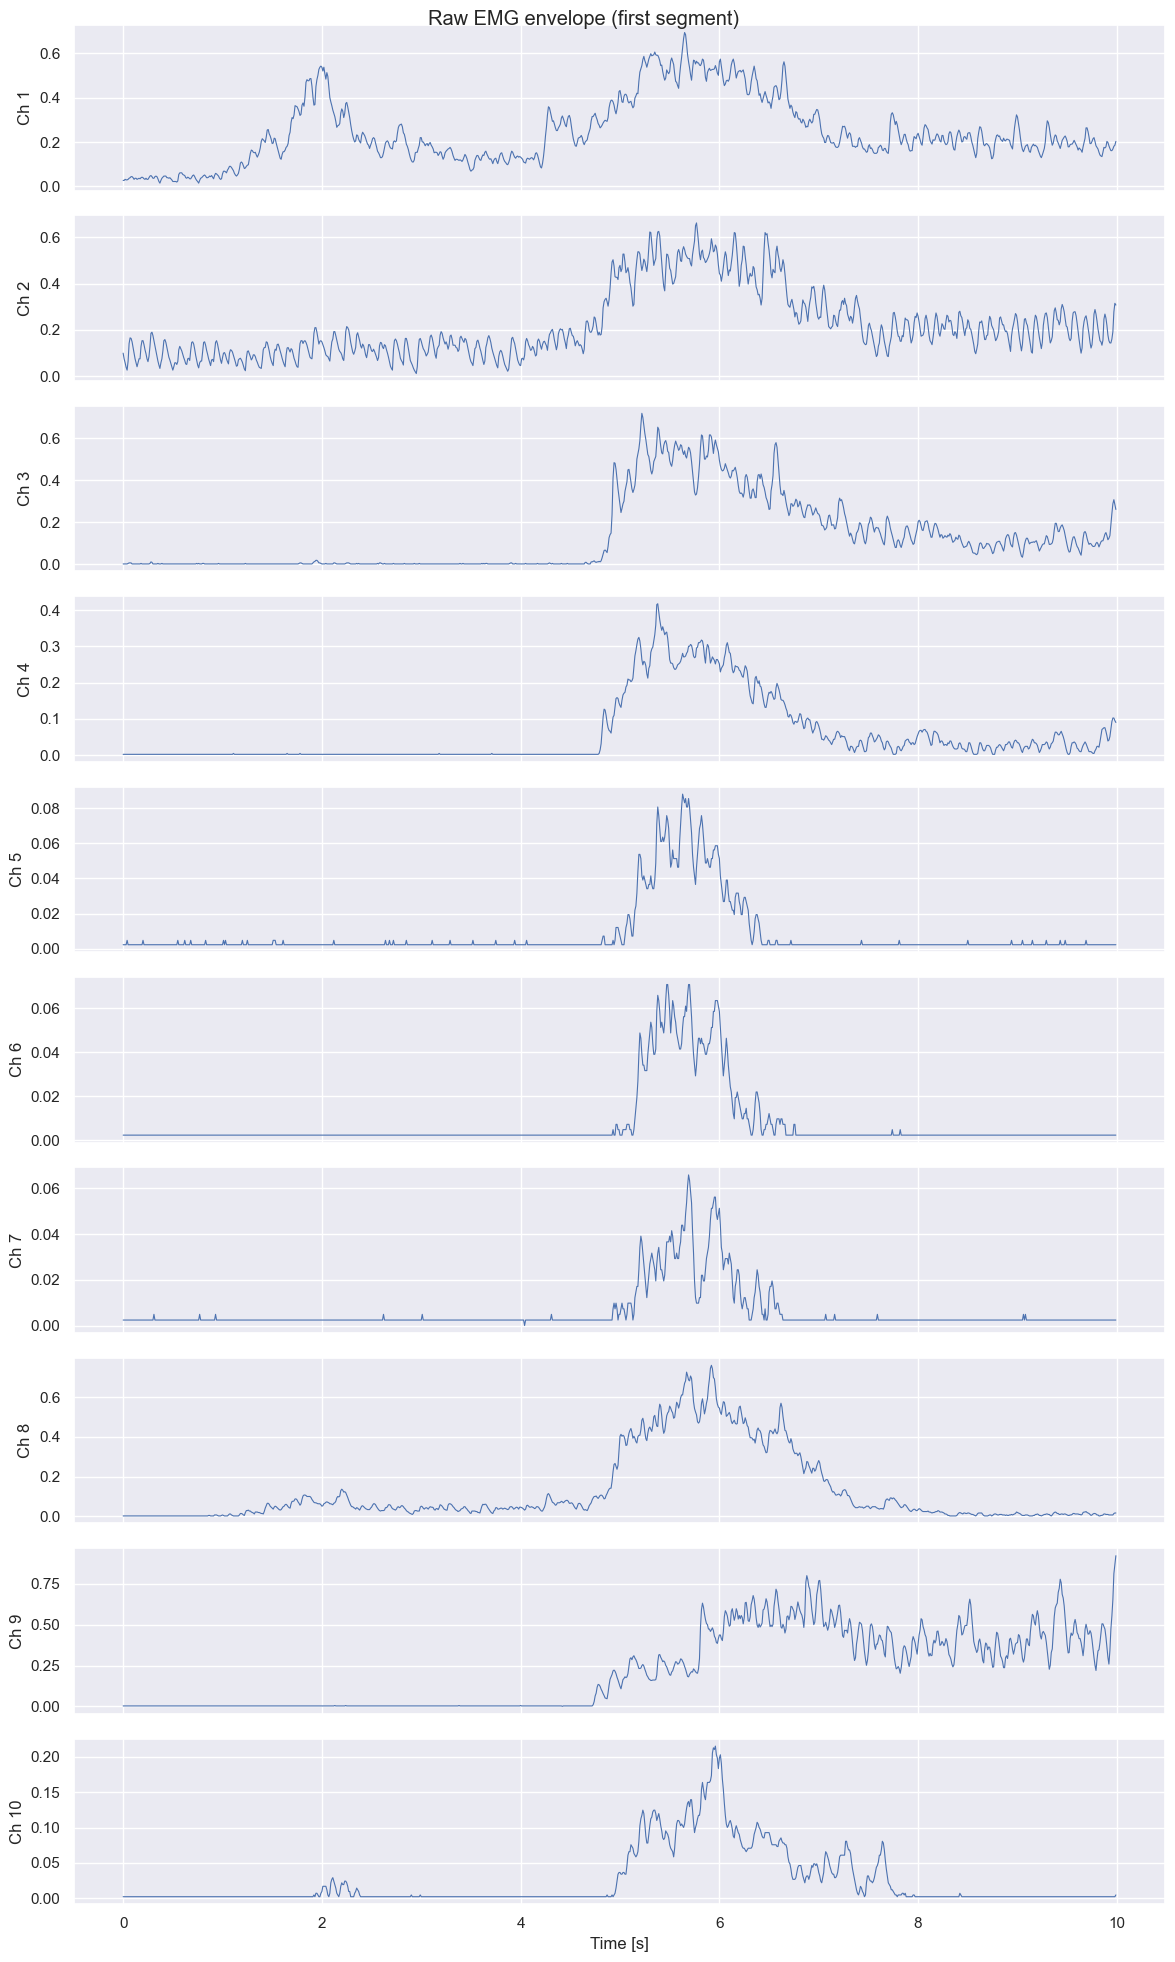

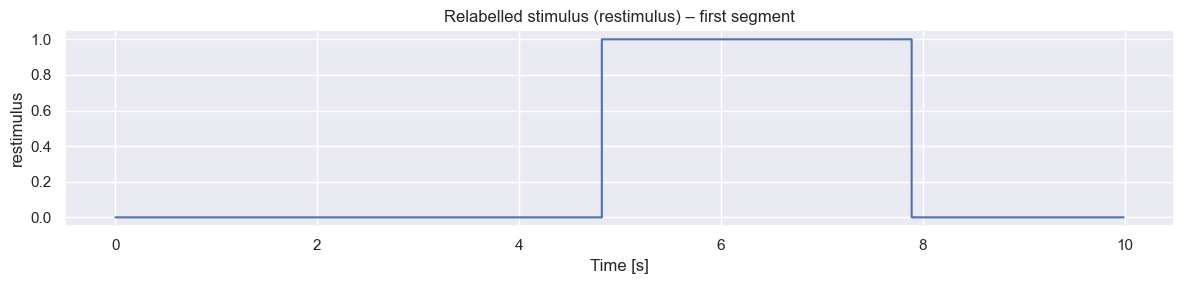

In [4]:
# Duration to visualize (in seconds)
duration_sec = 10
n_vis = min(int(duration_sec * fs), n_samples)
time_vis = np.arange(n_vis) / fs

fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2 * n_channels), sharex=True)
if n_channels == 1:
    axes = [axes]

for ch in range(n_channels):
    axes[ch].plot(time_vis, emg[:n_vis, ch], linewidth=0.8)
    axes[ch].set_ylabel(f"Ch {ch+1}")
axes[-1].set_xlabel("Time [s]")
fig.suptitle("Raw EMG envelope (first segment)")
plt.tight_layout()
plt.show()

# Plot relabelled stimulus over the same segment
plt.figure(figsize=(12, 3))
plt.step(time_vis, restimulus[:n_vis], where="post")
plt.xlabel("Time [s]")
plt.ylabel("restimulus")
plt.title("Relabelled stimulus (restimulus) – first segment")
plt.tight_layout()
plt.show()


**Preprocessing: low-pass filtering at 5 Hz**

According to the Ninapro / TNSRE paper:

- The Otto Bock electrodes already provide an **RMS EMG envelope** (amplified, band-pass filtered and rectified).
- The authors then apply a **low-pass Butterworth filter at 5 Hz (2nd order, zero-phase)** to further smooth the envelope.

We now apply this 5 Hz low-pass filter to all EMG channels.

In [5]:
# --- Design a 5 Hz low-pass Butterworth filter (2nd order) ---
cutoff_Hz = 5.0
order = 2

sos_lp = butter(N=order,
                Wn=cutoff_Hz,
                btype="low",
                fs=fs,
                output="sos")

# Apply zero-phase filtering to all channels
emg_lp = sosfiltfilt(sos_lp, emg, axis=0)

print("Filtered EMG shape:", emg_lp.shape)

Filtered EMG shape: (100686, 10)


**Visual comparison: raw vs low-pass filtered EMG**

To verify that the filter behaves as expected, we compare the original EMG envelope and the 5 Hz low-pass filtered version on a short time window for one channel.

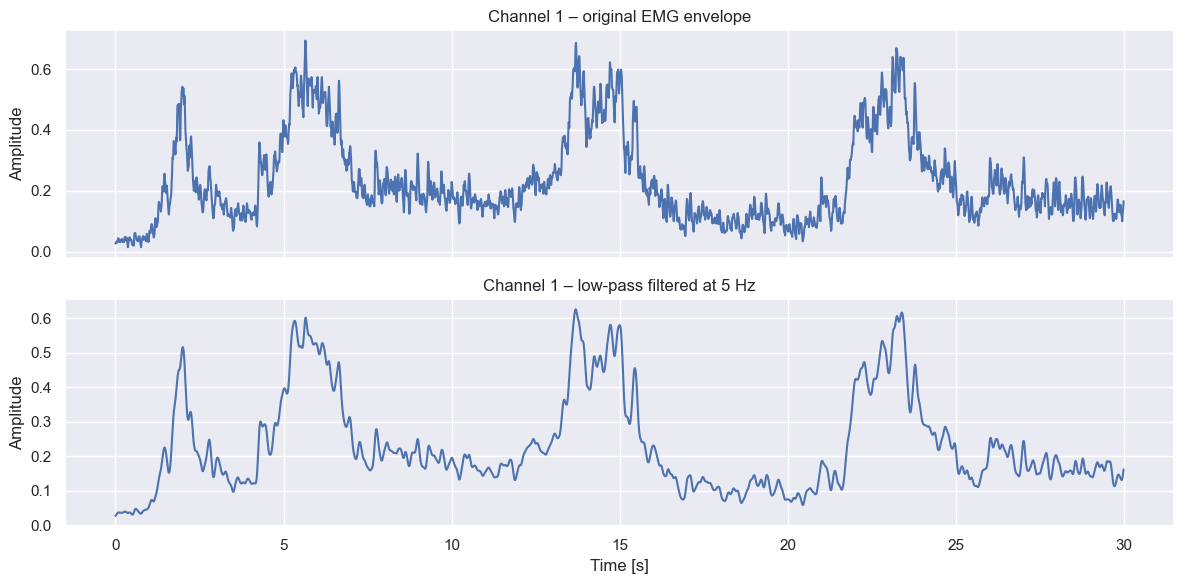

In [6]:
channel_to_plot = 0  # 0-based index
duration_sec = 30
n_vis = min(int(duration_sec * fs), n_samples)
time_vis = np.arange(n_vis) / fs

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax[0].plot(time_vis, emg[:n_vis, channel_to_plot])
ax[0].set_ylabel("Amplitude")
ax[0].set_title(f"Channel {channel_to_plot+1} – original EMG envelope")

ax[1].plot(time_vis, emg_lp[:n_vis, channel_to_plot])
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Amplitude")
ax[1].set_title(f"Channel {channel_to_plot+1} – low-pass filtered at 5 Hz")

plt.tight_layout()
plt.show()

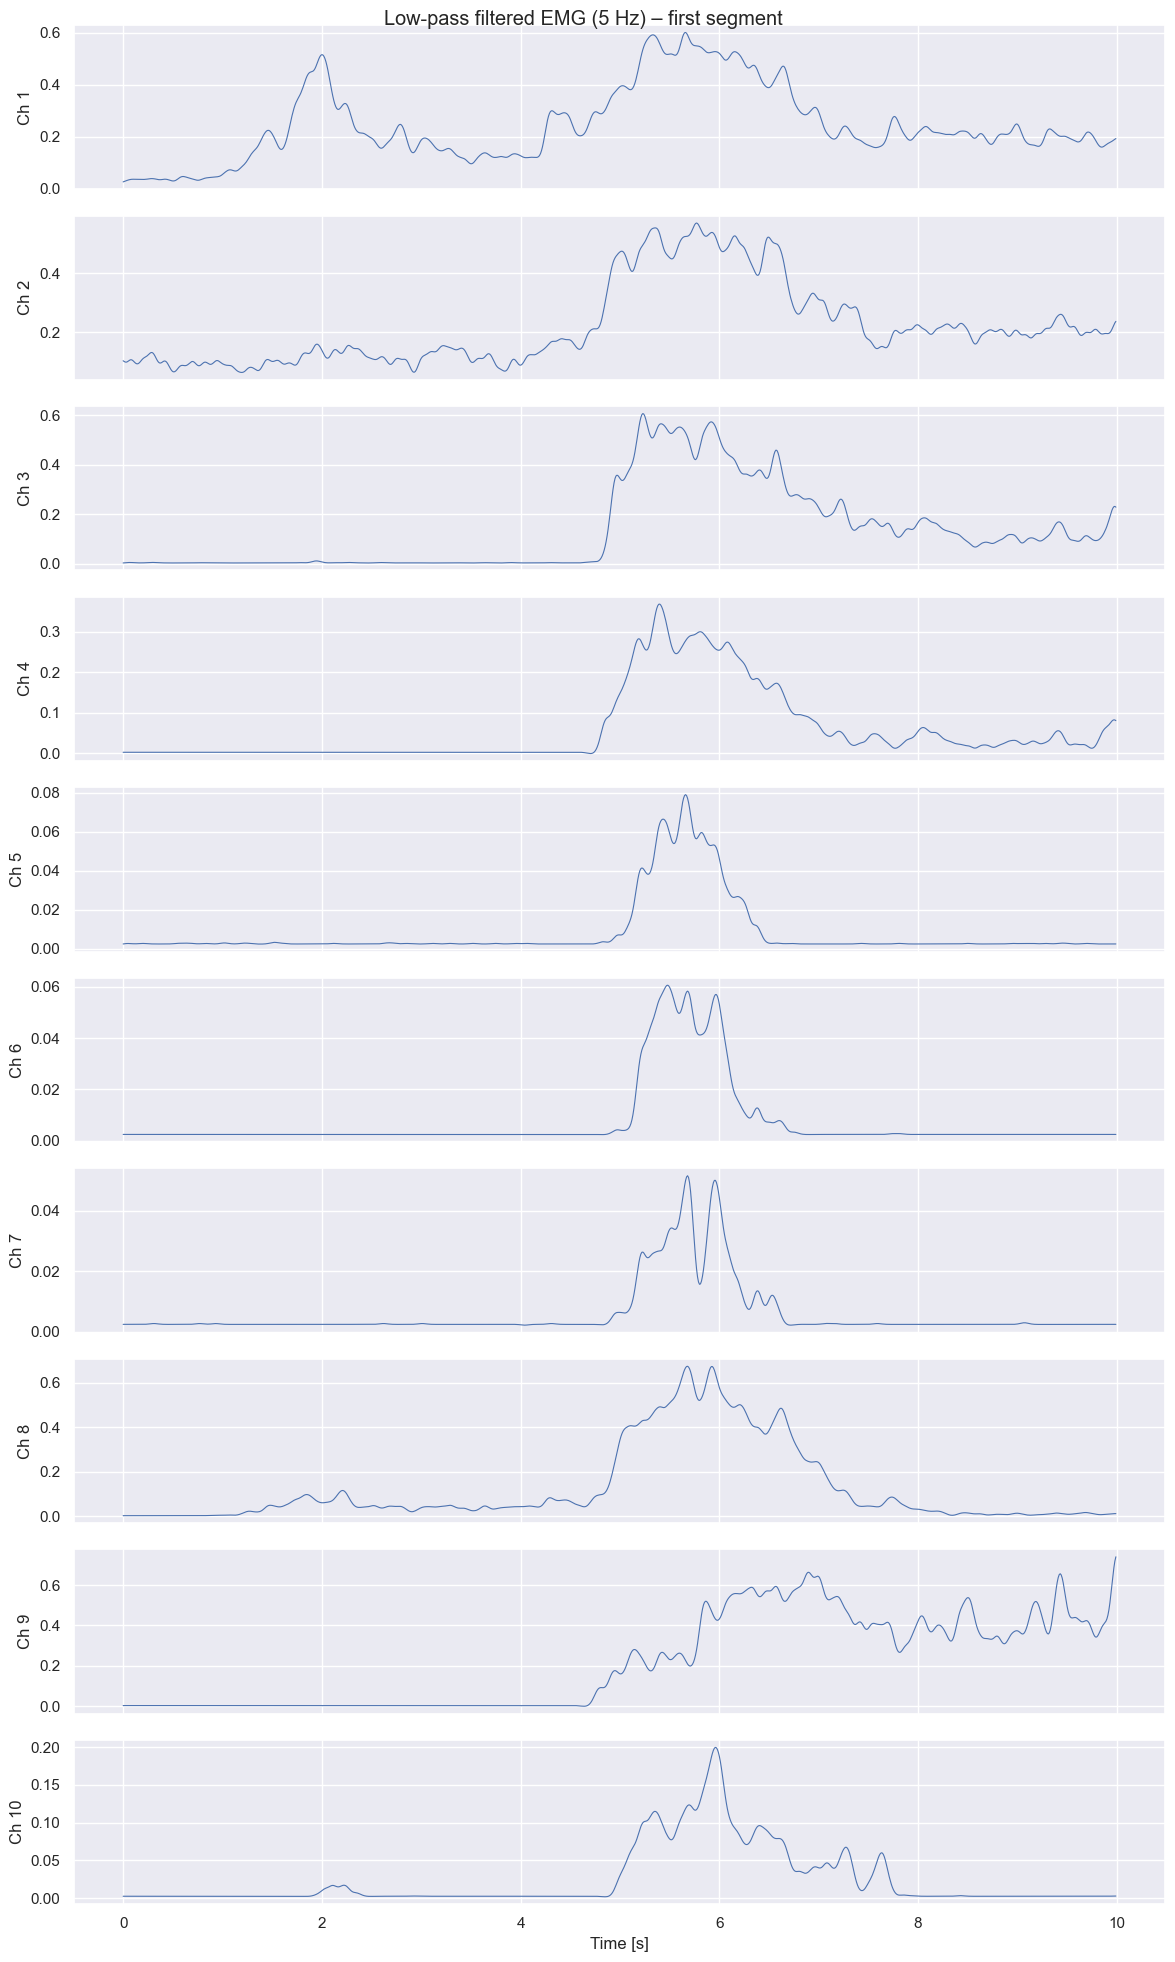

In [7]:
# We plot all channels after 5 Hz low-pass filtering (same segment as raw plot)
duration_sec = 10
n_vis = min(int(duration_sec * fs), n_samples)
time_vis = np.arange(n_vis) / fs

fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2 * n_channels), sharex=True)
if n_channels == 1:
    axes = [axes]

for ch in range(n_channels):
    axes[ch].plot(time_vis, emg_lp[:n_vis, ch], linewidth=0.8)
    axes[ch].set_ylabel(f"Ch {ch+1}")
axes[-1].set_xlabel("Time [s]")
fig.suptitle("Low-pass filtered EMG (5 Hz) – first segment")
plt.tight_layout()
plt.show()

**Trial-wise inspection (movement × repetition)**

The relabelled variables:

- `restimulus` (movement class, including 0 = rest),
- `rerepetition` (repetition index),

define trials as segments where both values are constant.

To check whether some repetitions look abnormal (e.g. very weak activation), we compute the **mean EMG amplitude per (movement, repetition)** on the filtered signal and visualize it as a heatmap.

Number of movements (excluding rest): 12
Number of repetitions: 10


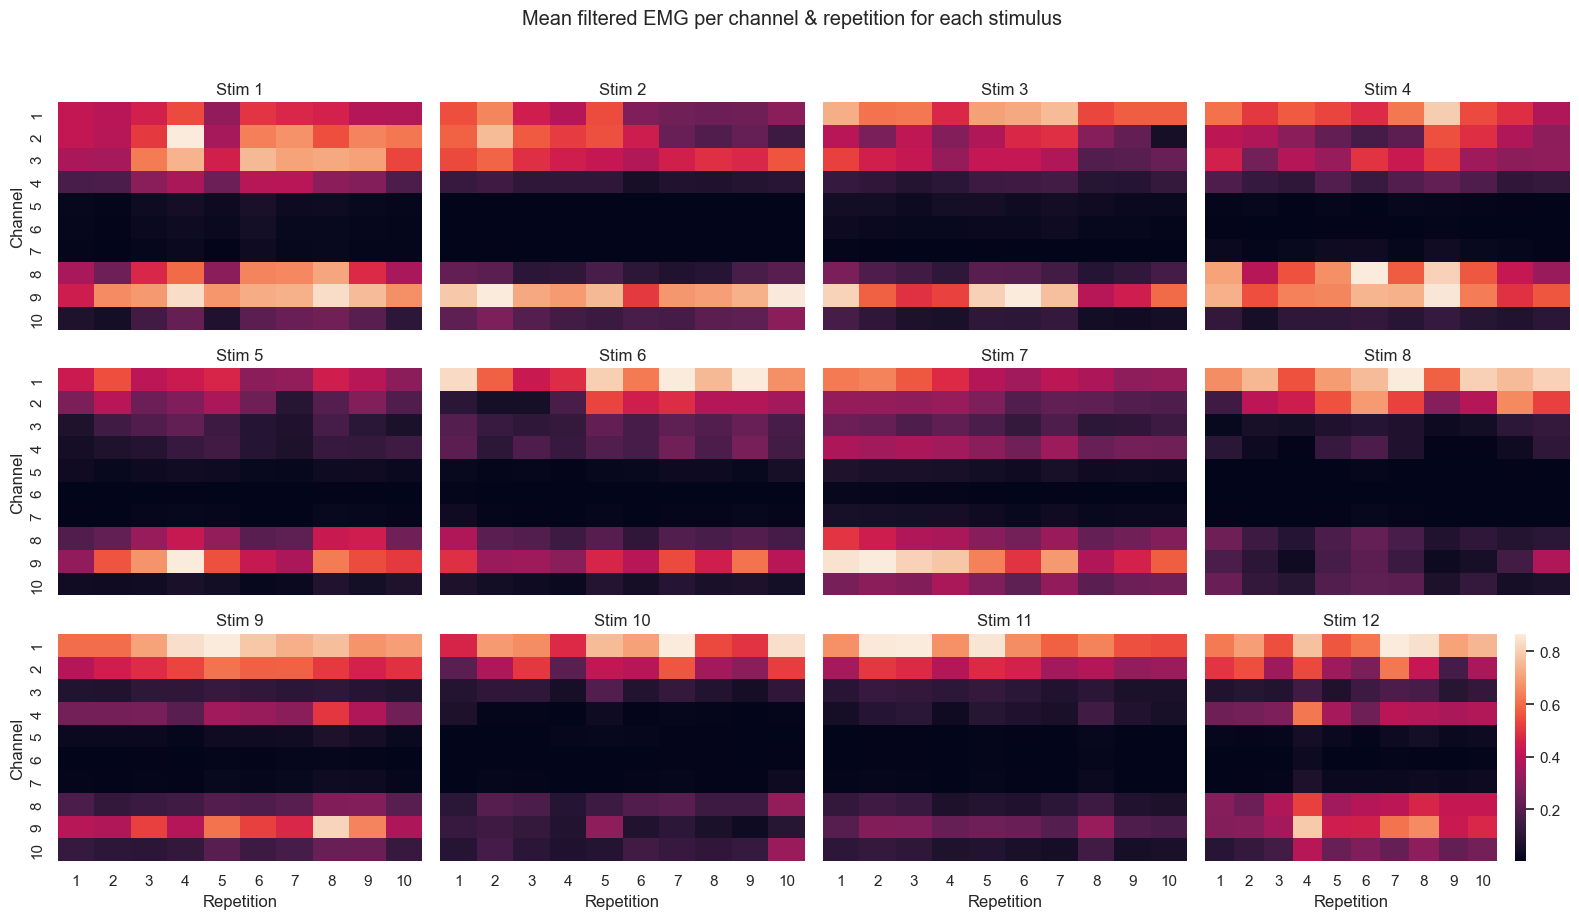

Variance of channel 1 : 0.20822645850365423
Variance of channel 2 : 0.08484612099826762
Variance of channel 3 : 0.03841790636040231
Variance of channel 4 : 0.04643012328522444
Variance of channel 5 : 0.0013161343958195606
Variance of channel 6 : 0.00017107004208903896
Variance of channel 7 : 0.0007938384938025719
Variance of channel 8 : 0.0821044956346604
Variance of channel 9 : 0.22625076462807245
Variance of channel 10 : 0.03061118281600645


In [8]:
# Unique movement labels, excluding rest (0)
unique_stimuli = np.unique(restimulus)
unique_stimuli = unique_stimuli[unique_stimuli != 0]

# Unique repetition indices, excluding 0
unique_reps = np.unique(rerepetition)
unique_reps = unique_reps[unique_reps != 0]

n_stimuli = len(unique_stimuli)
n_reps = len(unique_reps)

print("Number of movements (excluding rest):", n_stimuli)
print("Number of repetitions:", n_reps)

# Compute mean EMG amplitude per (channels, stimulus, repetition)
emg_average_activations = np.zeros((n_channels, n_stimuli, n_reps))

for i_s, s in enumerate(unique_stimuli):
    for i_r, r in enumerate(unique_reps):
        idx = (restimulus == s) & (rerepetition == r)
        if not np.any(idx):
            emg_average_activations[:, i_s, i_r] = np.nan
        else:
            emg_average_activations[:, i_s, i_r] = emg_lp[idx, :].mean(axis=0)

n_rows, n_cols = 3, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

axes = axes.flatten()  # pour indexer facilement

for i_s, s in enumerate(unique_stimuli):
    ax = axes[i_s]
    data_sr = emg_average_activations[:, i_s, :]

    sns.heatmap(
        data_sr,
        ax=ax,
        annot=False,
        xticklabels=[f"{r}" for r in unique_reps],
        yticklabels=[f"{c+1}" for c in range(n_channels)],
        cbar=(i_s == n_stimuli - 1),  
    )

    ax.set_title(f"Stim {s}")
    if i_s // n_cols == n_rows - 1:
        ax.set_xlabel("Repetition")
    else:
        ax.set_xlabel("")
    if i_s % n_cols == 0:
        ax.set_ylabel("Channel")
    else:
        ax.set_ylabel("")

for j in range(n_stimuli, n_rows * n_cols):
    axes[j].axis("off")

plt.suptitle("Mean filtered EMG per channel & repetition for each stimulus", y=1.02)
plt.tight_layout()
plt.show()

channel_var = emg_lp.var(axis=0)  # shape (n_channels,)
i=0
for elem in channel_var:
    i+=1
    print("Variance of channel", i, ":", elem)

**Conclusion for Part 1 – Question 1**

From the plots we can make the following observations:

- The EMG envelope (after 5 Hz low-pass filtering) shows clear activations for all channels during movement periods.
- The relabelled stimulus `restimulus` is consistent with the EMG activity (onsets and offsets match the bursts of activation).
- The trial-wise heatmap of mean EMG amplitude shows that:
  - all movements have non-zero activation,
  - repetitions are of comparable magnitude,
  - there are no repetitions with abnormally low or flat EMG.

**Answer to the question:**

- **Does the data look reasonable?**  
  Yes. The EMG signals for subject 2, exercise S2\_A1\_E1 look reasonable after preprocessing (5 Hz low-pass filtering), with clear activation patterns for each movement. The channel-wise variance analysis shows that channels 5, 6 and 7 have a much lower variance (≈10⁻⁴–10⁻³) than the other channels (≈3×10⁻²–2×10⁻¹), because their baseline is close to zero for most of the time. However, when looking at the time courses with channel-specific scaling, these channels still exhibit clear movement-related bursts aligned with the labels. We therefore interpret them as low-amplitude but informative channels, and we keep them for subsequent analyses.

- **Did you need to remove any trials?**  
  No. Based on the visual inspection and the trial-wise mean activation, there are no obvious corrupted or failed trials, so we keep all repetitions for this subject and exercise.


## Part1 : Question 2


In [9]:
from helpers import build_trial_index

trial_labels, trial_reps, trial_masks = build_trial_index(restimulus, rerepetition)
print("Number of trials:", len(trial_labels))  # should be 12 * 10 = 120

Number of trials: 120


**We split the data into training, validation and training**

In [10]:
from helpers import split_trials_by_repetition

TRAIN_REPS = np.array([1, 3, 4, 6, 7, 9])
VAL_REPS   = np.array([8])
TEST_REPS  = np.array([2, 5, 10])


train_trial_mask, val_trial_mask, test_trial_mask = split_trials_by_repetition(
    trial_reps, TRAIN_REPS, VAL_REPS, TEST_REPS
)

print("Train trials:", train_trial_mask.sum())
print("Val trials:  ", val_trial_mask.sum())
print("Test trials: ", test_trial_mask.sum())

Train trials: 72
Val trials:   12
Test trials:  36


For subject 2 (exercise S2_A1_E1), each of the 12 movements has 10 repetitions.
We split the data by repetitions, not by individual samples, so that all time
samples from a given repetition belong to the same subset (to avoid information
leakage between training and test sets).

We used the following split pattern for all movements:

- Training repetitions: {1, 3, 4, 6, 7, 9}  (6/10 ≈ 60%)
- Validation repetition: {8}                (1/10 ≈ 10%)
- Test repetitions: {2, 5, 10}              (3/10 ≈ 30%)

The training set is used to fit the classifier.
The validation set is used to make design choices and tune hyperparameters.
The test set is kept untouched and provides an unbiased estimate of
performance on unseen repetitions of the same movements.


## Part1 : Question 3

In [11]:
from helpers import mav, std_feature, max_av, rms, waveform_length

feature_fns = [mav, std_feature, max_av, rms, waveform_length]
feature_names = ["MAV", "STD", "MAX", "RMS", "WL"]

In [ ]:
from helpers import build_dataset_from_ninapro_lp, get_feature_matrix_for_feature_index

X_trials, y_trials, trial_reps = build_dataset_from_ninapro_lp(
    emg_lp=emg_lp,
    stimulus=restimulus,
    repetition=rerepetition,
    features=feature_fns,
)

X_train, y_train = X_trials[train_trial_mask], y_trials[train_trial_mask]
X_val,   y_val   = X_trials[val_trial_mask],   y_trials[val_trial_mask]
X_test,  y_test  = X_trials[test_trial_mask],  y_trials[test_trial_mask]


n_feat_per_channel = len(feature_fns)
n_channels = emg_lp.shape[1]

mav_index = feature_names.index("MAV")
mav_vals = get_feature_matrix_for_feature_index(X_trials, mav_index, n_channels)
# mav_vals shape: (n_trials, n_channels)

movement_to_plot = 1
mask_movement = (y_trials == movement_to_plot)

mav_movement = mav_vals[mask_movement, :]          # shape (n_trials_for_this_movement, n_channels)
reps_movement = trial_reps[mask_movement]          # which repetitions these rows correspond to

# Sort trials by repetition index for nicer plotting
order = np.argsort(reps_movement)
mav_movement = mav_movement[order, :]
reps_sorted = reps_movement[order]

plt.figure(figsize=(8, 5))
sns.heatmap(
    mav_movement.T,    # channels x repetitions
    annot=False,
    xticklabels=[f"rep {r}" for r in reps_sorted],
    yticklabels=[f"ch {c+1}" for c in range(n_channels)],
)
plt.xlabel("Repetition")
plt.ylabel("Channel")
plt.title(f"MAV per channel and repetition (movement {movement_to_plot})")
plt.tight_layout()
plt.show()